## PGAE for 1D MT inversion
### Created on Oct 1st 2019
### Lian Liu: lianliu1017@126.com

### 1. import modules

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, Input, Model, regularizers
import numpy as np
import cmath as cm
import matplotlib.pyplot as plt
from time import time
import sys
sys.path.append(r'/work/ess-liul/Geophysics/MTPGAE')
from MT1D_fwd import mt1d_analytic, mt1d_analytic_tensor
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2024-11-08 22:32:13.137930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2. design neural networks

In [9]:
def MT_net(input_size, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel):
    model = models.Sequential()
    model.add(layers.Dense(500, 
                            activation = 'relu', # softplus
                            use_bias = True, 
                            kernel_initializer = tf.constant_initializer(weight_dense1), 
                            bias_initializer = tf.constant_initializer(bias_Dense1), 
                           
                            name = 'dense1', 
                            input_shape = (input_size, )))
    
    # model.add(tf.keras.layers.BatchNormalization())
    # model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(geomodel_size, 
                           # activation = 'relu', 
                           use_bias = True, 
                           kernel_initializer = tf.constant_initializer(weight_geomodel), 
                           bias_initializer = tf.constant_initializer(bias_geomodel), 
                           
                           name = 'geomodel'))
    
    model.add(layers.Lambda(lambda x: mt1d_analytic_tensor(x)))

    return model

### 3. plot figures

note: used for synthetic data

In [15]:
def plot_comparison(resis, rho_sd, geomodel_pre, rho_real, dz_real, freq):
    rho_fit = mt1d_analytic_tensor(tf.constant(geomodel_pre))
    rho_fit = rho_fit.numpy()
    rho_fit = 10. ** (rho_fit * 4.0)
    rho_real = 10. ** (rho_real * 4.0)
    
    # plot
    resis_inverted = 10.0 ** (4.0 * np.array(geomodel_pre)).reshape(-1)
    dz_invert = 20. + (10.** (0.115 * np.arange(1, geomodel_pre.shape[1] - 1, 1))).reshape([1, -1])
    dz_invert = np.hstack([np.array([[20.]]), dz_invert])
    # dz_invert = 5.0 * (1.23**np.arange(0, geomodel_pre.shape[1] - 1, 1)).reshape([1, -1])
    z_inverted = np.cumsum(np.insert(dz_invert, 0, 1, axis = 1))
    z_inverted = np.append(z_inverted, 10000)
    
    z_real = np.cumsum(np.insert(dz_real, 0, 1, 1))
    z_real = np.append(z_real, 10000)
    
    resis_real = np.insert(resis[0], 0, resis[0][0], 0)
    resis_inverted = np.insert(resis_inverted, 0, resis_inverted[0], 0)
    
    plt.figure(figsize = (3, 6))
    ####################################plot resistivities####################################
    ax1 = plt.axes([0.20, 0.6, 0.73, 0.38]) # [x, y, width, height]
    
    ax1.step(z_real, resis_real, linewidth = 2., color = 'tab:blue')
    ax1.step(z_inverted, resis_inverted, linewidth = 2., color = 'tab:orange')
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    plt.xlim((1e0, 1e4))
    plt.ylim((1e0, 1e4))
    plt.xlabel('Depth (m)', fontsize = 12)
    plt.ylabel('Resistivity (ohm.m)', fontsize = 12)
    plt.xticks(np.logspace(0, 4, 5), fontsize = 10.5)
    plt.yticks(np.logspace(0, 4, 5), fontsize = 10.5)
    ax1.legend(['Real', 'Inverted'], loc = 'best', fontsize = 10.5)
    
    ####################################plot rho####################################
    ax2 = plt.axes([0.20, 0.10, 0.73, 0.38]) # [x,y,width,height]
    
    # plt.plot(freq, rho_real[0, :], linewidth = 2.)
    # plt.plot(freq, rho_fit[0, :], linewidth = 2., color = 'tab:orange')
    # ax2.errorbar(freq, rho_real[0, :], yerr = rho_sd, fmt = '', ecolor = 'r', color = 'tab:blue', elinewidth = 2, linewidth = 2)
    ax2.plot(freq, rho_fit[0, :], linewidth = 2., color = 'tab:orange')
    ax2.errorbar(freq, rho_real[0, :], yerr = 1.*rho_sd.reshape(-1), fmt = '', ecolor = 'r', color = 'tab:blue', elinewidth = 2, linewidth = 2)
    ax2 = plt.gca()
    ax2.invert_xaxis()
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    plt.xlim((1e4, 1e0))
    plt.ylim((1e0, 1e4))
    plt.xlabel('Frequency (Hz)', fontsize = 12)
    plt.ylabel('Rho (ohm.m)', fontsize = 12)
    plt.xticks(np.logspace(4, 0, 5), fontsize = 10.5)
    plt.yticks(np.logspace(0, 4, 5), fontsize = 10.5)
    ax2.legend(['Inverted', 'Real'], loc = 'best', fontsize = 10.2)
    # plt.legend(['Without noise','Inverted','With noise'], loc='best', fontsize = 15)
    # plt.savefig('Resis_and_rho.tiff', dpi = 300, format = 'tiff')
    plt.show()

### 5. run

#### 5.2 set up network params

In [16]:
geomodel_size = 31 # output size of predict network
input_size = 25

In [ ]:
# load network params
weight_dense1 = np.loadtxt('/work/ess-liul/Geophysics/MTPGAE/ANN/weight_dense1.txt', delimiter = ',')
weight_geomodel = np.loadtxt('/work/ess-liul/Geophysics/MTPGAE/ANN/weight_geomodel.txt', delimiter = ',')
bias_Dense1 = np.loadtxt('/work/ess-liul/Geophysics/MTPGAE/ANN/bias_Dense1.txt', delimiter = ',')
bias_geomodel = np.loadtxt('/work/ess-liul/Geophysics/MTPGAE/ANN/bias_geomodel.txt', delimiter = ',')

In [18]:
model = MT_net(input_size, geomodel_size, weight_dense1, weight_geomodel, bias_Dense1, bias_geomodel)

pred_model = Model(inputs = model.input, 
                    outputs = model.get_layer('geomodel').output)
# pred_model.summary()

#### 5.4 Predicting

##### 5.4.1 Predicting according to synthetic data and plot resistivity and rho

1/1 [==============================] - 0s 44ms/step


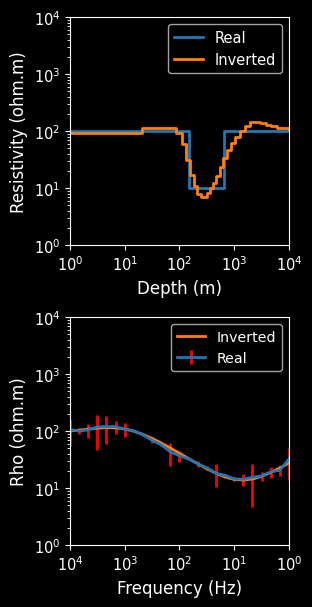

In [25]:
errorfloor = 0.1
dz = np.array([[50, 100, 500]])
resis = np.array([[100, 100, 10, 100]])
freq = np.logspace(4, 0, 25).reshape(-1, 1)
zxy, z_sd, rho, rho_sd = mt1d_analytic(freq, dz, 1. / resis, errorfloor)
rho = rho.reshape(1, -1)
rho = np.log10(rho) / 4.0
geomodel_pre = pred_model.predict(rho)
# np.savetxt(r'geomodel_pre_syn.txt', geomodel_pre_syn, fmt = "%g", delimiter = ',')
plot_comparison(resis, rho_sd, geomodel_pre, rho, dz, freq)

### End